In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


In [35]:
# Load and preprocess data
df = pd.read_csv(r'/content/stroke.csv')
warnings.filterwarnings('ignore')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [37]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [38]:
df.bmi.replace(to_replace=np.nan, value=df.bmi.mean(),inplace=True)

In [39]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [40]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['ever_married'] = le.fit_transform(df['ever_married'])
df['work_type'] = le.fit_transform(df['work_type'])
df['Residence_type'] = le.fit_transform(df['Residence_type'])
df['smoking_status'] = le.fit_transform(df['smoking_status'])

In [41]:
# Separate features and labels
X = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [42]:
# Apply SMOTE to address class imbalance
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [43]:
# Calculate and plot mutual information
mutual_info = mutual_info_classif(X_train_res, y_train_res)
mutual_info_series = pd.Series(mutual_info, index=df.columns[1:-1]).sort_values(ascending=False)

In [44]:
models = [
    ['XGBClassifier', XGBClassifier(learning_rate=0.1, objective='binary:logistic', random_state=0, eval_metric='logloss')],
    ['Logistic Regression', LogisticRegression(random_state=42)],
    ['SVM', SVC(probability=True, random_state=42)],
    ['KNeighbors', KNeighborsClassifier()],
    ['GaussianNB', GaussianNB()],
    ['Gradient Boost', GradientBoostingClassifier(random_state=42)],
    ['Decision Tree', DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, criterion='entropy', min_samples_split=5, splitter='random', random_state=1)],
    ['Random Forest', RandomForestClassifier(random_state=42)],
]

In [45]:

# Track the best model based on accuracy
best_accuracy = 0
best_model = None
best_model_name = ''

# Train and evaluate each model
for name, model in models:
    model.fit(X_train_res, y_train_res)
    if hasattr(model, "predict_proba"):
        y_pred = np.argmax(model.predict_proba(X_test), axis=1)
    else:
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name}:")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Accuracy Score:", accuracy)
    print()

    # Update the best model if current model's accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

print(f"Best Model: {best_model_name} with Accuracy: {best_accuracy}")


XGBClassifier:
Confusion Matrix:
 [[962   6]
 [ 50   4]]
Accuracy Score: 0.9452054794520548

Logistic Regression:
Confusion Matrix:
 [[754 214]
 [ 17  37]]
Accuracy Score: 0.773972602739726

SVM:
Confusion Matrix:
 [[708 260]
 [ 14  40]]
Accuracy Score: 0.7318982387475538

KNeighbors:
Confusion Matrix:
 [[806 162]
 [ 27  27]]
Accuracy Score: 0.815068493150685

GaussianNB:
Confusion Matrix:
 [[726 242]
 [ 15  39]]
Accuracy Score: 0.7485322896281801

Gradient Boost:
Confusion Matrix:
 [[957  11]
 [ 52   2]]
Accuracy Score: 0.9383561643835616

Decision Tree:
Confusion Matrix:
 [[708 260]
 [ 12  42]]
Accuracy Score: 0.7338551859099804

Random Forest:
Confusion Matrix:
 [[964   4]
 [ 52   2]]
Accuracy Score: 0.9452054794520548

Best Model: XGBClassifier with Accuracy: 0.9452054794520548


Best model saved as 'stroke_model.json'.


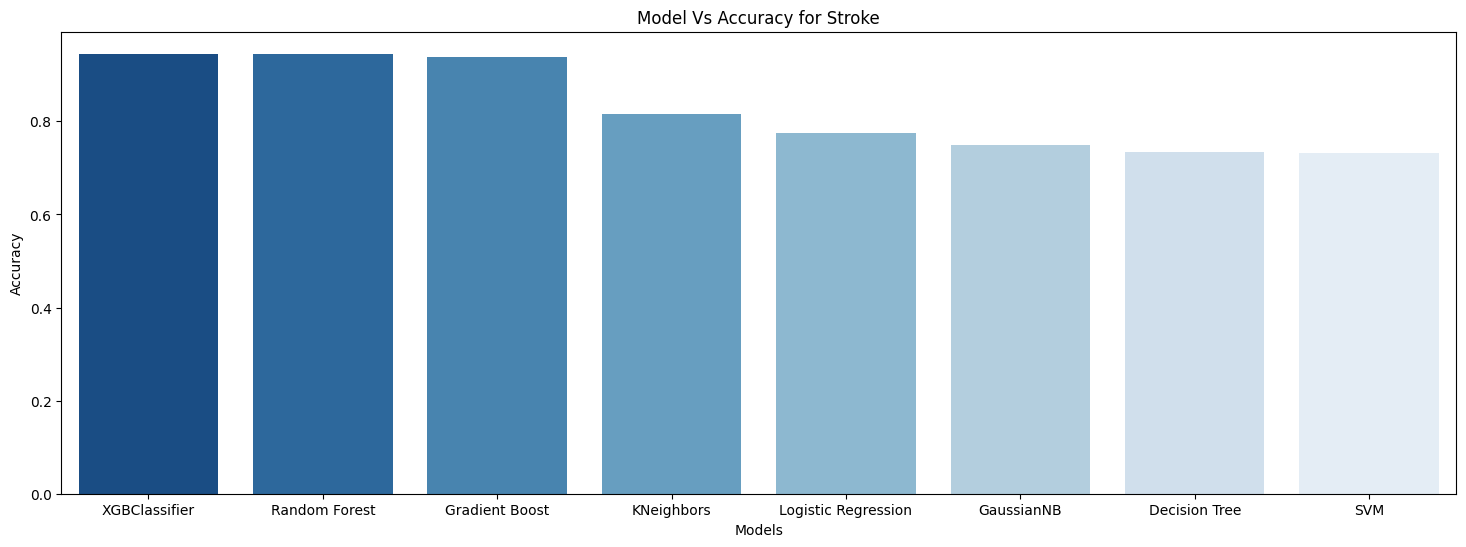

In [46]:
# Plot accuracy for all models
model_names = [name for name, _ in models]
accuracies = [accuracy_score(y_test, np.argmax(model.predict_proba(X_test), axis=1) if hasattr(model, "predict_proba") else model.predict(X_test)) for _, model in models]
df1 = pd.DataFrame({'Models': model_names, 'Accuracy': accuracies}).sort_values(by="Accuracy", ascending=False)

plt.figure(figsize=(18, 6))
sns.barplot(x='Models', y='Accuracy', data=df1, palette='Blues_r')
plt.title("Model Vs Accuracy for Stroke")

# Save the best model in JSON format
best_model.save_model("stroke_model.json")
print("Best model saved as 'stroke_model.json'.")